### Reading Input Files

In [1]:
import pandas as pd


#Read the flood intensity file
FloodIntensity = pd.read_csv('FloodIntensityFile_AIRton_2021.dat', delimiter=',')

#Convert int values to string values (in the format of "XXYY") regarding the "GridID" column
FloodIntensity['GridID'] = FloodIntensity['GridID'].apply(lambda x: str(x).zfill(4))


#Read the building mapping file
BuildingMapping = pd.read_excel('InsurAIR_BuildingDamageFunction.xlsx', sheet_name='Mapping', header=1)

#Remove empty rows and columns
BuildingMapping = BuildingMapping.iloc[:, 1:]

#Read the building damage function file
BuildingDamage = pd.read_excel('InsurAIR_BuildingDamageFunction.xlsx', sheet_name='Damage Function', header=1)

#Rename columns, the column "ID_X" represents the damage ratio curve of a specific building ID
BuildingDamage.columns = ['Flood Depth'] + ['ID_' + str(i) for i in range(1, BuildingDamage.shape[1])]


#Read the time element damage function file
TimeElementDamage = pd.read_excel('InsurAIR_TimeElementDamageFunction.xlsx', sheet_name='Damage Function', header=1)

#Rename columns, the column "ID_X" represents the downtime curve of a specific building ID (only one ID was given here)
TimeElementDamage.columns = ['Damage Ratio'] + ['ID_' + str(i) for i in range(1, TimeElementDamage.shape[1])]


#Read the exposure portfolio file
Exposure = pd.read_csv('InsurAIR_ExposurePortfolio_2021.csv')

#Convert string values to float values regarding the last 2 columns
Exposure.iloc[:,-2:] = Exposure.iloc[:,-2:].applymap(lambda x: float(x.replace(',','')))

### Definition of Different Functions

In [2]:
import math
import numpy as np


#Define the intensity function, where inputs include the event ID and building coordinates (i.e., location_lon, location_lat)
#The flood intensity file is used to map the GridID and the flood intensity
#The output is the flood intensity value (i.e., the flood depth)
def IntensityFunction(eventID, location_lon, location_lat, FloodIntensity):
    
    #For a specific event, intensity values at all nodes of the grid are stored in the dictionary "gridID_intensity"
    EventIntensity = FloodIntensity[FloodIntensity['EventID'] == eventID]
    gridID_intensity = dict(zip(EventIntensity['GridID'], EventIntensity['Intensity']))
    
    #For a location within the grid, the intensity value is considered as the average intensity of four corners of a cell
    #For a location on the boundary, the intensity value is considered as the average intensity of two nodes of a line segment
    #For a location outside the 9*9 grid, find the nearest point on the boundry of the grid as the intensity value
    #For example, (9.7, 1.1) is treated as (9, 1.1); (9.7, 9.7) is treated as (9, 9); (-1, -1) is treated as (0, 0)
    
    #For a value < 0 or > 9, make it 0 or 9, make sure all values fall into the range from 0 to 9
    #Therefore, the location coordinate outside the boundry can be considered
    f = lambda x: 0 if x < 0 else (9 if x > 9 else x)
    location_lon = f(location_lon)
    location_lat = f(location_lat)
    
    #For a location coordinate, find four corners of a cell in the format of "XXYY"
    #Use the dictionary "gridID_intensity" to find four intensity values and then take the average
    #For a location on the boundry or at a cell corner, it can be considered as well
    x0y0 = str(math.floor(location_lon)).zfill(2) + str(math.floor(location_lat)).zfill(2)
    x1y0 = str(math.ceil(location_lon)).zfill(2) + str(math.floor(location_lat)).zfill(2)
    x0y1 = str(math.floor(location_lon)).zfill(2) + str(math.ceil(location_lat)).zfill(2)
    x1y1 = str(math.ceil(location_lon)).zfill(2) + str(math.ceil(location_lat)).zfill(2)
    flood_depth = (gridID_intensity[x0y0] + gridID_intensity[x1y0] + gridID_intensity[x0y1] + gridID_intensity[x1y1])/4
    
    return flood_depth


#Define the building damage function
#"Occupancy, construction, number_of_stories" determines the building ID type through the building mapping file
#The flood depth is used to determine the damage ratio through the building damage function file
#The output is the building ID and the damage ratio
def BuildingDamageFunction(occupancy, construction, number_of_stories, flood_depth, BuildingMapping, BuildingDamage):
    
    #Map the building ID to a list [occupancy, construction, number_of_stories] through the building mapping file
    ID_mapping = BuildingMapping.set_index('ID').T.to_dict('list')
    
    #Find the building ID of a specific building location
    ID = list(ID_mapping.keys())[list(ID_mapping.values()).index([occupancy, construction, number_of_stories])]
    
    #Use the building ID to determine which curve to use, then calculate the damage ratio according to the flood depth
    #Interpolation is used to calculate the damage ratio
    #If flood_depth < 0, damage_ratio = 0.0; if flood_depth > 12, damage_ratio = 1.0
    damage_ratio = np.interp(flood_depth, BuildingDamage['Flood Depth'], BuildingDamage['ID_' + str(ID)])
    
    return (ID, damage_ratio)


#Define the time element damage function
#The ID and the damage ratio are used to determine the downtime through the time element damage function file
#The output is the downtime
def TimeElementDamageFunction(ID, damage_ratio, TimeElementDamage):
    
    #Theoretically there should be 3 curves regarding 3 building IDs. However, only ID_1 related curve was provided.
    #Therefore the ID value was modified to 1 in the downtime calculation
    ID = 1 #It can be deleted if multiple curves are provided
    
    #Interpolation is used to calculate the downtime according to the damage ratio
    downtime = np.interp(damage_ratio, TimeElementDamage['Damage Ratio'], TimeElementDamage['ID_' + str(ID)])
    
    return downtime

### LocationEventLossTable Generation

In [3]:
#Generate the first column of LocationEventLossTable
LossTable = pd.DataFrame({'Event Number': FloodIntensity['EventID'].unique()})


#Loop through all locations
for locationID in Exposure['Location ID']:
    
    #Find the index of a row where a specific location ID is located
    i = Exposure[Exposure['Location ID'] == locationID].index.tolist()[0]
    
    #Create two lists to store values of "Location X - Building Loss" and "Location X - Time Element Loss"
    building_loss_list, time_element_loss_list = [], []
    
    #Loop through all events
    for eventID in FloodIntensity['EventID'].unique():
        
        #Calculate the flood depth through the intensity function
        location_lon = Exposure['Location Lon'][i]
        location_lat = Exposure['Location Lat'][i]
        flood_depth = IntensityFunction(eventID, location_lon, location_lat, FloodIntensity)
        
        #Calculate the damage ratio using the flood depth through the building damage function
        occupancy = Exposure['Occupancy'][i]
        construction = Exposure['Construction'][i]
        number_of_stories = Exposure['Number of Stories'][i]
        result = BuildingDamageFunction(occupancy, construction, number_of_stories, flood_depth, BuildingMapping, BuildingDamage)
        ID = result[0]
        damage_ratio = result[1]
        
        #Calculate the building loss and store the value in the "building_loss" list
        building_loss = damage_ratio * Exposure['Building Replacement Value'][i]
        building_loss_list.append(building_loss)
        
        #Calculate the downtime using the damage ratio through the time element damage function
        downtime = TimeElementDamageFunction(ID, damage_ratio, TimeElementDamage)
        
        #Calculate the time element loss and store the value in the "time_element_loss" list
        time_element_loss = downtime * Exposure['Perdiem Loss of Business  Revenue/Perdiem Additional Living Expense'][i]
        time_element_loss_list.append(time_element_loss)
    
    #Generate columns of "Building Loss", "Time Element Loss", and "Total Loss" regarding each location
    LossTable['Location '+str(locationID)+' – Building Loss'] = building_loss_list
    LossTable['Location '+str(locationID)+' – Time Element Loss'] = time_element_loss_list
    total_loss = np.array(building_loss_list) + np.array(time_element_loss_list)
    LossTable['Location '+str(locationID)+' – Total Loss (Building + Time Element Loss)'] = total_loss

#Generate and initialize the last three columns
LossTable['InsurAIR portfolio – Building Loss'] = 0
LossTable['InsurAIR portfolio – Time Element Loss'] = 0
LossTable['InsurAIR portfolio – Total Loss (Building + Time Element Loss)'] = 0

#Calculate values of the last three columns
for locationID in Exposure['Location ID']:
    LossTable['InsurAIR portfolio – Building Loss'] += LossTable['Location '+str(locationID)+' – Building Loss']
    LossTable['InsurAIR portfolio – Time Element Loss'] += LossTable['Location '+str(locationID)+' – Time Element Loss']
    LossTable['InsurAIR portfolio – Total Loss (Building + Time Element Loss)'] += LossTable['Location '+str(locationID)+' – Total Loss (Building + Time Element Loss)']


#Output the LocationEventLossTable
LossTable.to_csv('LocationEventLossTable_InsurAIR_RenZheng.dat', index=False)

### Exceedance Probability Curve Generation

In [4]:
#Read the generated LocationEventLossTable and extract "Event Number" & "Total Loss" columns
TotalLoss = pd.read_csv('LocationEventLossTable_InsurAIR_RenZheng.dat', delimiter=',')
TotalLoss = TotalLoss.iloc[:,[0,-1]]


#In the given flood intensity file, the "Year" column and the "EventID" column are exactly the same
#A general situation is multiple events might happen in a specific year
#The following codes provide a general method to aggregate events in a given year, although it is not necessary for this question
eventID_year = dict(zip(FloodIntensity['EventID'], FloodIntensity['Year']))
TotalLoss['Year'] = TotalLoss['Event Number'].apply(lambda x: eventID_year[x])

#Event-level losses are added in a given year
TotalLoss = TotalLoss.groupby('Year', as_index=False).agg({'InsurAIR portfolio – Total Loss (Building + Time Element Loss)':'sum'})


#Define the EP function, where the input is a "loss value" series and the output is a "EP value" series
def ExceedanceProbability(pd_series):
    return [(pd_series >= value).astype(int).sum()/(len(pd_series)) for value in pd_series]


#Calculate EP values through the EP function and store them in the "Exceedance Probability" column
EPCurve = pd.DataFrame({'Exceedance Probability': ExceedanceProbability(TotalLoss.iloc[:,-1])})

#Calculate "Return Period" values and store them in the "Return Period" column
EPCurve['Return Period'] = EPCurve['Exceedance Probability'].apply(lambda x: 1/x)

#Add the "Total Loss" column
EPCurve['InsurAIR portfolio – Total Loss (Building + Time Element Loss)'] = TotalLoss.iloc[:,-1]

#Sort values from highest to lowest regarding the "Exceedance Probability" column
EPCurve.sort_values('Exceedance Probability', ascending=False, inplace=True)

#Calculate AAL using the "Total Loss" column
AAL = TotalLoss.iloc[:,-1].mean()

#Calculate the EP pf AAL using the EP curve
EP_AAL = np.interp(AAL, EPCurve.iloc[:,-1], EPCurve['Exceedance Probability'])

#Add a row regarding AAL calculation on top
AAL_row = pd.DataFrame({'Exceedance Probability':EP_AAL, 
                        'Return Period':1/EP_AAL,
                        'InsurAIR portfolio – Total Loss (Building + Time Element Loss)':AAL}, index=[0])
EPCurve = pd.concat([AAL_row, EPCurve]).reset_index(drop=True)


#Output the Exceedance Probability Curve Table
EPCurve.to_csv('EPCurve_InsurAIR_RenZheng.dat', index=False)

### Visualization

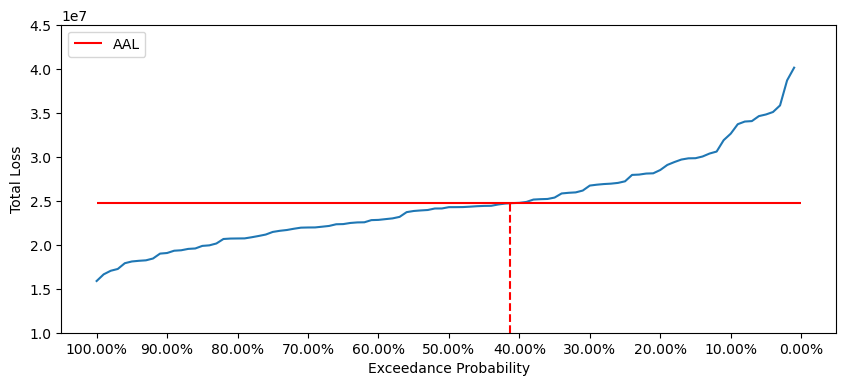

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

fig, ax = plt.subplots(figsize=(10, 4))

ax.plot(EPCurve.iloc[1:,0], EPCurve.iloc[1:,-1])
ax.hlines(AAL, 0, 1, color='r', label='AAL')
ax.vlines(EP_AAL, 1e7, AAL, color='r', linestyle='dashed')

ax.set_xticks(np.linspace(0, 1, 11))
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=2))
ax.invert_xaxis()
ax.set_ylim(1e7, 4.5e7)

ax.set_xlabel('Exceedance Probability')
ax.set_ylabel('Total Loss')
ax.legend(loc='upper left')

plt.show()